# Seismic modeling

In [1]:
# Import module __future__ for python 2/3 compatibility
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

# Import numpy and matplotlib
import numpy as np
import matplotlib.pyplot as plt

# Import functions needed for modeling
from nessi.swm import modext, modbuo, modlame
from nessi.swm import acqpos, pmlmod
from nessi.swm import ricker, srcspread
from nessi.swm import evolution

## Input parameters

In [2]:
# >> Run parameters
jobname = 'test'
tmax = 1.0
dt = 0.0001

# >> Grid dimensions and node spacing
n1 = 51
n2 = 301
dh = 0.5

# >> Boundaries parameters
isurf = 1 # Free surface
npml = 20  # width in points of the PML bands
apml = 600.
ppml = 8

# >> Acquisition parameters
nrec = 48
drec = 2.0
xrec0 = 28.
zrec0 = dh
dts = 0.0001

# >> Source parameters
xs = 10.0; zs = 0.5 # source position
f0 = 15.0; t0 = 0.1 # peak frequency and t0
sigma = -1.
srctype = 2

# >> Snapshots
isnap = 0
dtsnap = 0.001

## Calculate complementary parameters

In [3]:
nt = int(tmax/dt)+1
nts = int(tmax/dts+1)
ntsnap = int(tmax/dtsnap)+1

## Generate homogeneous seismic velocity and density models

For this example, homogeneous seismic wave velocity and density models are used. So, they are generated on the fly. However, these models can be loaded from text or binary files using functions `np.loadtxt()` or `np.fromfile()`. 

In [4]:
vp = np.zeros((n1, n2), dtype=np.float32)
vs = np.zeros((n1, n2), dtype=np.float32)
ro = np.zeros((n1, n2), dtype=np.float32)

vp[:, :] = 600.  # m/s
vs[:, :] = 200.  # m/s
ro[:, :] = 1500. # kg/m3

## Extent models

Here, the seismic velocity and density models are extended by adding PML bands around.

In [5]:
vpe = modext(npml, vp)
vse = modext(npml, vs)
roe = modext(npml, ro)

## Calculate buoyancy and Lame parameters

The seismic modeling algorithm does not use directly Vp, Vs and density but the Lame's parameters and the buoyancy (inverse of the density).

In [6]:
bux, buz = modbuo(roe)
mu, lbd, lbdmu = modlame(vpe, vse, roe)

## Calculate PMLs

In [7]:
pmlx0,pmlx1,pmlz0,pmlz1 = pmlmod(n1,n2,dh,isurf,npml,apml,ppml)

## Generate input acquisition

As for seismic velocity models, the acquisition can be load from text using `np.loadtxt`. In this case, the acquisition file must have two columns: (1) receiver position in meter for the x coordinate, and (2) receiver depth in meter for the z coordinate. Each line corresponds to a receiver position but ordering does not matter. 

In [8]:
acq = np.zeros((nrec, 2), dtype=np.float32)
for irec in range(0, nrec):
    acq[irec,0] = xrec0+float(irec)*drec
    acq[irec,1] = zrec0

recpos = acqpos(n1, n2, npml, dh, acq)

## Generate input source

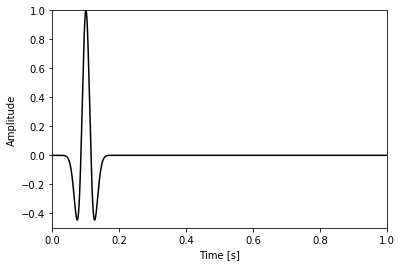

In [9]:
# >> Source spread grid
gsrc = srcspread(n1, n2, npml, xs, zs, dh, sigma)

# >> Ricker source
tsrc = ricker(nt, dt, f0, t0)

# >> Ploting source
t = np.linspace(0., float(nt-1)*dt, nt)
plt.xlim(0., t[-1])
plt.ylim(-0.5, 1.)
plt.xlabel(r"Time [s]")
plt.ylabel(r"Amplitude")
plt.plot(t, tsrc, color='black');

## Calculate stability condition

In [10]:
print("Courant:: ", dt*np.amax(vpe)/dh)

Courant::  0.12000000000000001


## Time marching

In [11]:
recx,recz,recp = evolution(n1,n2,dh,npml,nts,ntsnap,dt,srctype,tsrc,gsrc,recpos,isurf,isnap,bux,buz,lbd, lbdmu,mu,pmlx0,pmlx1,pmlz0,pmlz1)

## Ploting outputs

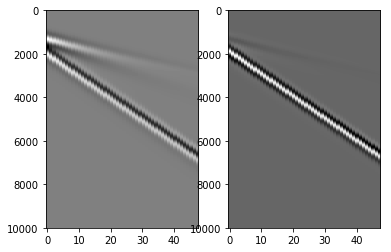

In [12]:
plt.subplot(121)
plt.imshow(recx, aspect='auto', cmap='gray')
plt.subplot(122)
plt.imshow(recz, aspect='auto', cmap='gray');